In [1]:
import numpy as np
# import cupy as cp
from numba import cuda
import math
import scipy.signal as scs
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pickle

### load data

In [2]:
# Data were acquired using ur4R_lite system.
# Plane Wave Imaging (PWI) sequence was used in measurement.

# Load data from a file.
filename = 'pwi_wire_angles-10_0_10_50V_context.pkl'
file = open(filename,'rb')
datadict = pickle.load(file)

# metadata, from the parameters will be taken
metadata = datadict['metadata']


# radio-frequency data
rf = datadict['data']

# sampling frequency
dwnsmp = metadata['sequence']['downsampling_factor']
fs = metadata['device']['sampling_frequency']/dwnsmp

# pitch
pitch = metadata['device']['probe']['model']['pitch']

# transmission angles
tx_angle = metadata['sequence']['angles']

# speed of sound
c = metadata['sequence']['speed_of_sound']

# carrier frequency
fc = metadata['sequence']['pulse']['center_frequency']

# 
n_periods = metadata['sequence']['pulse']['n_periods']


if 'tx_focus' in metadata['sequence']:
    tx_focus = metadata['sequence']['tx_focus']

else:
    tx_focus = 0
    print('pwi sequence: tx_focus = 0')
    

print('Data loaded.')


pwi sequence: tx_focus = 0
Data loaded.


# Ultrasound image reconstruction using numba/cuda kernel

## function definitions

In [3]:
# device function (for a single thread) 'float64(float64, float64, float64,  float64[:], float64,float64,float64[:,:])', 
@cuda.jit(device=True)
def pixel(px, pz, angle, elx, c, fs, rf):
    """
    Device function. 
    Returns the value in single pixel of the reconstructed image 
    for Plane Wave Imaging scheme with tx angle = 0 degree.
    
    px: x coordinate of the image pixel,
    pz: z coordinate of the image pixel,
    angle: wave angle of incidence,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,
    rf: 2D array of ultrasound signals acquired by the transducer. 
        rf.shape = (number_of_elements, number_of_samples)
    """
    
    if angle >= 0:
        pw = elx[0]
    else:
        pw = elx[-1]

    # sum suitable samples from signals acquired by each transducer element
    pixval = 0
    for ielement in range(elx.shape[0]):
        sample_number = round((pz*math.cos(angle) - pw*math.sin(angle) + px*math.sin(angle) +
                               math.sqrt(pz**2 + (px-elx[ielement])**2)
                              )/c*fs+1)
        pixval += rf[ielement,sample_number]

    return pixval   
    
      
    
# kernel function
@cuda.jit
def pixels(xgrid, zgrid, angle, elx,c,fs,rf,image):
    """
    Kernel function.
    Enumerates values in all pixels of the reconstructed image
    for Plane Wave Imaging scheme with tx angle = 0 degree.
    
    xgrid: 2D array of image pixels x coordinates,
    zgrid: 2D array of image pixels z coordinates,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,
    rf: ultrasound signals acquired by the transducer,
    image: pre-allocated device ndarray for image data
    """
    
    # thread indexing
    x, y = cuda.grid(2)
    
    # condition 
    if x > xgrid.shape[0] or y > xgrid.shape[1]:
        return
    
    image[x,y] = pixel(xgrid[x,y],zgrid[x,y],angle[0],elx,c,fs,rf)   


def beamforming(xgrid, zgrid, angle, elx,c,fs,rf):
    """
    Function beamforming ultrasound data into image using GPU kernel.
    Returns beamformed image (ndarray).

    xgrid: 2D array of image pixels x coordinates,
    zgrid: 2D array of image pixels z coordinates,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,
    rf: ultrasound signals acquired by the transducer,
    """
    
    nx = xgrid.shape[1]
    nz = zgrid.shape[0]
    
    # allocate output array on the device
    img = cuda.device_array((nz,nx))
    
    # put data and grid arrays to the device
    xgrid = cuda.to_device(xgrid)
    zgrid = cuda.to_device(zgrid)
    elx = cuda.to_device(elx)
    rf = cuda.to_device(rf)
    angle = cuda.to_device(angle)
    
    # define thread per block and blocks per grid size
    threadsperblock = (32,32)
    blockspergrid_y = (xgrid.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_x = (xgrid.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    # run kernel
    pixels[blockspergrid,threadsperblock](xgrid, zgrid, angle, elx, c, fs,rf,img)
    
    # transfer data from device to host
    img = img.copy_to_host()
    return img

def envdb(img):
    """
    Auxiliary function for image envelope detection and log-compression.
    """
    
    env = np.abs(scs.hilbert(img,axis=0))
    mx = np.max(env)
    env = env/mx
    env = 20*np.log10(env)
    return env

## The use of defined functions on previously loaded data

the transmit angle is: [0.]
CPU times: user 522 ms, sys: 72.3 ms, total: 594 ms
Wall time: 639 ms


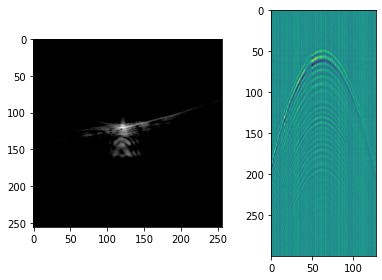

In [4]:
# getting some size parameters
n_transmissions,n_channels,n_samples  = rf.shape
    
probe_width = (n_channels-1)*pitch
elx = np.linspace(-probe_width/2, probe_width/2, n_channels)

# create image grid coordinates
x_mm = [-5,5]
z_mm = [20,30]
nx = 256
nz = 256
c = 1490
fs = 65e6
                          
xgrid = np.linspace(x_mm[0]*1e-3,x_mm[1]*1e-3,nx)
xgrid = np.expand_dims(xgrid,axis=0)
xgrid = np.tile(xgrid,(nz,1))

zgrid = np.linspace(z_mm[0]*1e-3,z_mm[1]*1e-3,nz)
zgrid = np.expand_dims(zgrid,axis=1)
zgrid = np.tile(zgrid,(1,nx))


# chose the angle (chose it wisely...)
i = 1
angle = tx_angle[i]
angle = np.array([angle])
print(f'the transmit angle is: {angle/np.pi*180}')
rfith = rf[i,:,:]


# do beamforming
%time rf_bmf2 = beamforming(xgrid,zgrid,angle,elx,c, fs,rfith)



# present results

# calculate data aspect for proper image proportions
dx = x_mm[1]-x_mm[0]
dz = z_mm[1]-z_mm[0]
data_aspect = dz/dx


fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(envdb(rf_bmf2),
            interpolation='bicubic',
            aspect=data_aspect,
            cmap='gray',
            vmin=-30, vmax=0
              )

axes[1].imshow(rf[i,:,2100:2400].T)
fig.tight_layout()